In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using TensorFlow backend.


Initialized TensorFlow


In [ ]:
# Method 1 (current): continuous regularization, 2nd layer matrix
# Method 2: L1 input, balanced neurons 1 layer

In [93]:
def get_exp(scale = 1.0, epochs = 15, N = [200, 100], reg_coeff = 0.0005):
    # scaling the architecture up/down
    #N = [int(t * scale) for t in N]
    N = [int(N[0] * scale), N[1]]

    def get_p_arr(p):
        """ p array with failure on the first layer """
        return [0, p]  + [0] * len(N)

    # Lips. coeff
    KLips = 1.

    # activation function
    activation = 'sigmoid'

    # training the network
    exp = MNISTExperiment(N = N, p_inference = get_p_arr(0), p_train = get_p_arr(0), KLips = KLips, epochs = epochs,
                                      activation = activation, reg_type = 'continuous', reg_coeff = reg_coeff, do_print = 'plot',
                                      name = 'experiment_weights', seed = None, batch_size = 100)
    
    # returning the weights in the middle
    return exp

In [72]:
def get_activation_profile(exp, input_idx = 0, plot = True):
    """ Get a smooth activation profile """

    # obtaining the model
    m = exp.model_correct

    # obtaining the tf session
    sess = get_session()

    print('val_acc=%.2f' % exp.history.history['val_categorical_accuracy'][-1])

    # showing the regularization output
    print("int [W'_{t_1}(t_1,t_0)]=%.2f" % sess.run(Continuous()(exp.W[0].T)))

    # some input
    x = exp.x_train[input_idx:input_idx + 1]

    # obtaining the activation profile
    out1 = sess.run(m.layers[0].output, feed_dict = {m.input: x})

    if plot:
        # plotting the activation profile
        plt.plot(out1[0])
        plt.ylabel('$y_i$')
        plt.xlabel('$i_1=1..n_1$')
        plt.show()
    
    return out1[0]

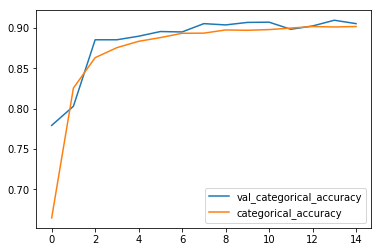

val_acc=0.91
int [W'_{t_1}(t_1,t_0)]=1.32


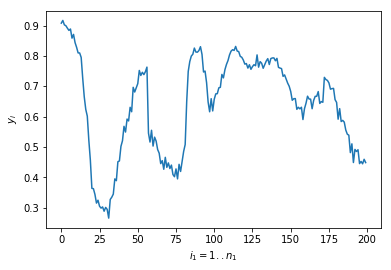

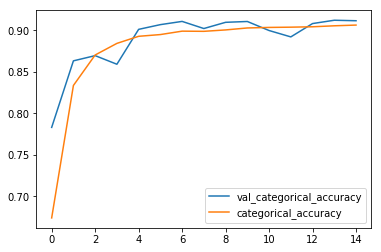

val_acc=0.91
int [W'_{t_1}(t_1,t_0)]=1.33


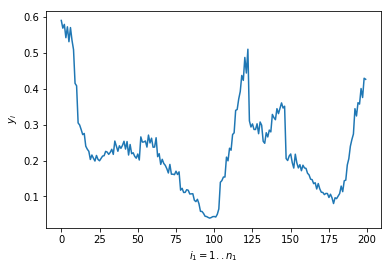

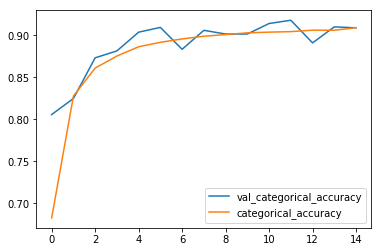

val_acc=0.91
int [W'_{t_1}(t_1,t_0)]=1.33


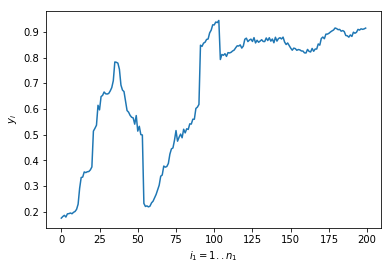

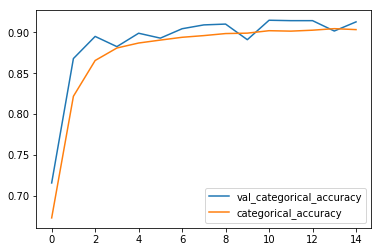

val_acc=0.91
int [W'_{t_1}(t_1,t_0)]=1.34


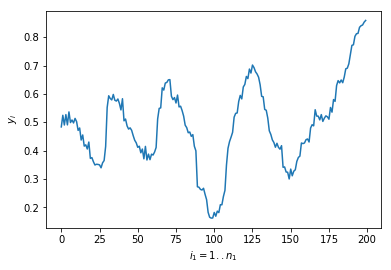

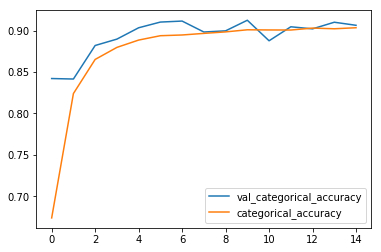

val_acc=0.91
int [W'_{t_1}(t_1,t_0)]=1.33


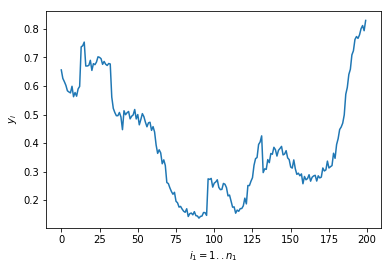

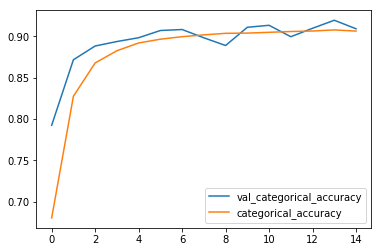

val_acc=0.91
int [W'_{t_1}(t_1,t_0)]=1.33


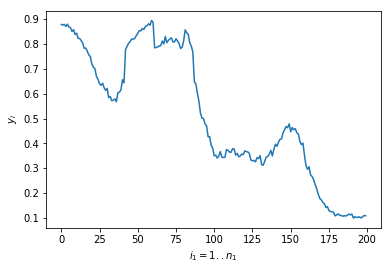

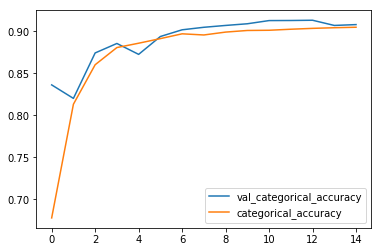

val_acc=0.91
int [W'_{t_1}(t_1,t_0)]=1.34


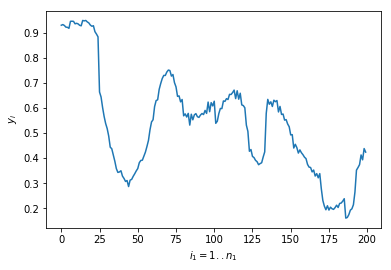

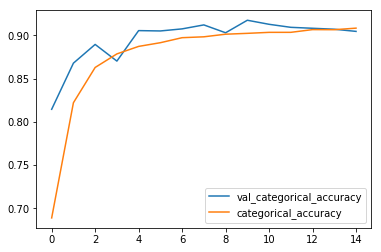

val_acc=0.90
int [W'_{t_1}(t_1,t_0)]=1.33


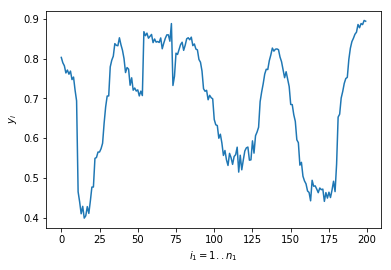

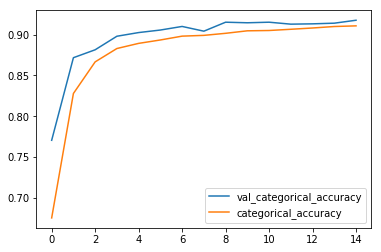

val_acc=0.92
int [W'_{t_1}(t_1,t_0)]=1.34


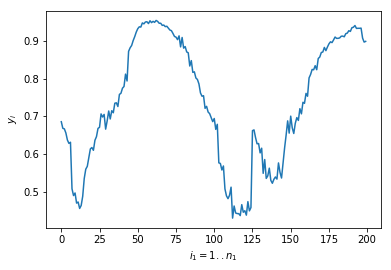

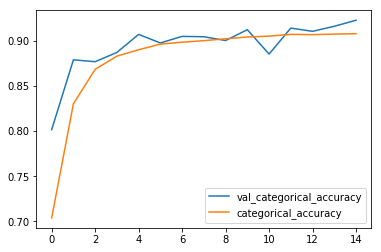

val_acc=0.92
int [W'_{t_1}(t_1,t_0)]=1.33


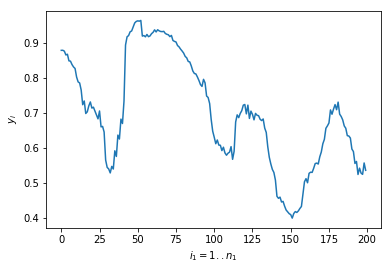

In [75]:
profiles = []
for _ in range(10):
    profile = get_activation_profile(get_exp())
    profiles.append(profile)

In [97]:
# saving data
np.savetxt('WeightDistribution-Continuity-FC-MNIST-Layer1-Activations.txt', profiles)

In [98]:
# old 1/n_l^2 coeff in front
# coeff=0.001,0.01,0.1,1,10 -> too big change, no continuity
# coeff=10 accuracy 0.9 some regularity, coeff=100
# added biases, removed 1/n_l scaling -> 0.001 gives a smooth activation profile!

# added biases, fixed 1/n_l
# 0.0001 too small, 0.001 accuracy decr -> 0.0005
# trying with increased scale... repeat
# trying with increased scale... they are different...

In [99]:
def get_W(**kwargs):
    """ Get a W[1] """
    # obtaining the experiment object
    exp = get_exp(**kwargs)
    
    get_activation_profile(exp, plot = True)

    # next layer must have continuous inputs...
    
    return exp.W[1]

In [100]:
# all scales of the network (up and down)
scales = np.linspace(0.5, 5, 5)

# repetitions for each scale
repetitions = 3

print('Total runs: %d' % (len(scales) * repetitions))

Total runs: 15


In [101]:
def process_scale(s):
    """ Run many repetitions for one scale """
    return [get_W(scale = s, epochs = 15) for _ in range(repetitions)]

def process_all():
    """ Random variable with all results """
    return {scale: process_scale(scale) for scale in tqdm(scales)}




  0%|          | 0/5 [00:00<?, ?it/s]

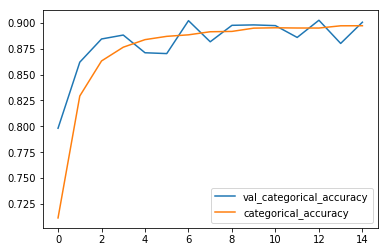

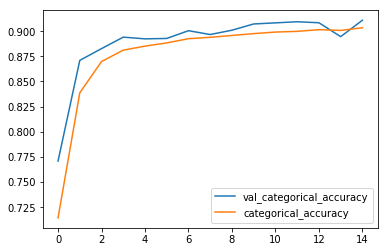

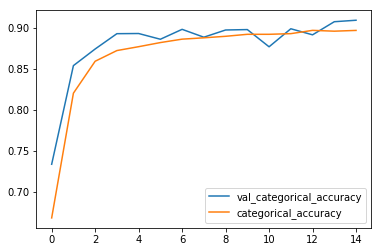




 20%|██        | 1/5 [07:20<29:22, 440.54s/it]

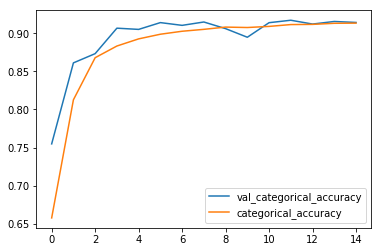

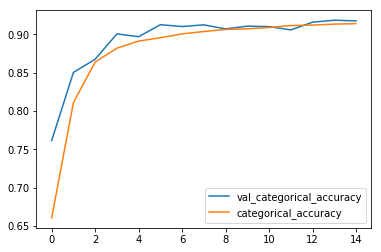

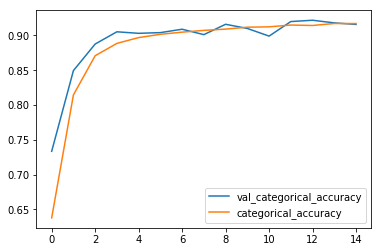




 40%|████      | 2/5 [23:45<30:11, 603.96s/it]

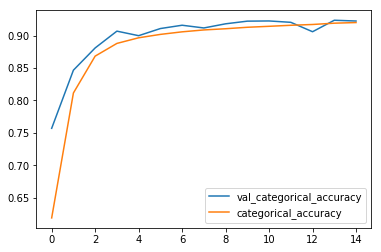

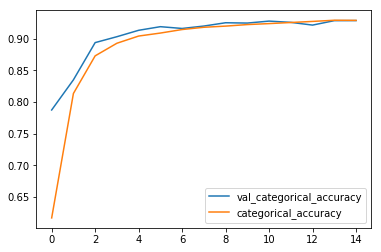

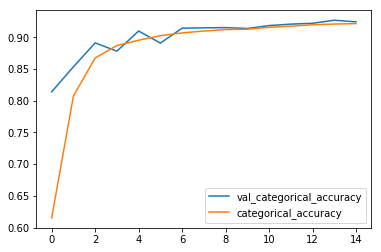




 60%|██████    | 3/5 [49:25<29:29, 884.68s/it]

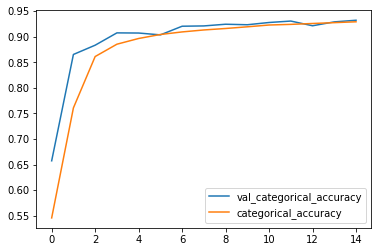

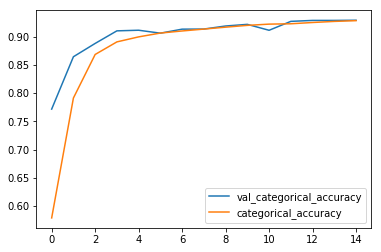

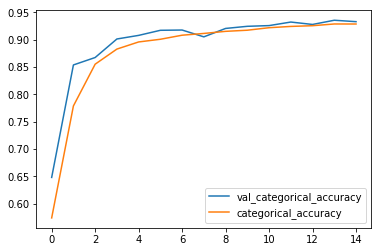




 80%|████████  | 4/5 [1:23:04<20:24, 1224.86s/it]

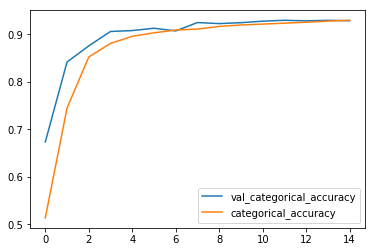

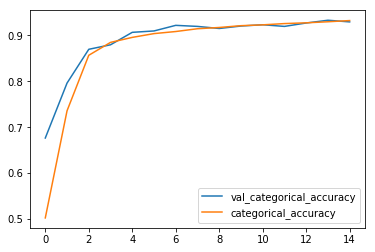

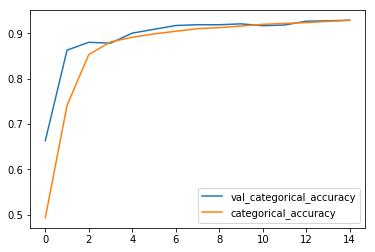




100%|██████████| 5/5 [2:09:23<00:00, 1691.28s/it]

In [102]:
# obtaining the results
results = process_all()

0.5 0 0.12874343 0.16300759
0.5 1 0.12691529 0.15998214
0.5 2 0.12790516 0.16285151


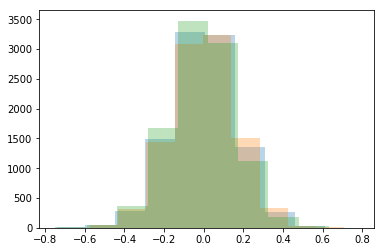

1.625 0 0.06956739 0.08894976
1.625 1 0.07059351 0.089777164
1.625 2 0.0707093 0.089946724


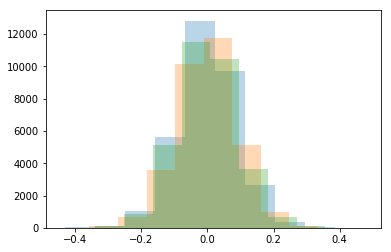

2.75 0 0.054109342 0.06878985
2.75 1 0.0538767 0.068702355
2.75 2 0.05428718 0.06903724


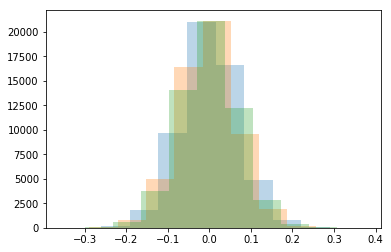

3.875 0 0.044673726 0.056829646
3.875 1 0.045221303 0.05749987
3.875 2 0.045193885 0.05757442


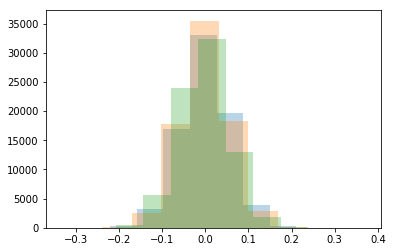

5.0 0 0.039738994 0.05063107
5.0 1 0.03965487 0.050607152
5.0 2 0.039629288 0.050415043


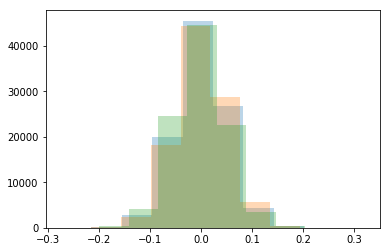

In [104]:
# trained 20 epochs
for scale in scales:
    plt.figure()
    for i in range(repetitions):
        distr = results[scale][i].flatten()
        print(scale, i, np.mean(np.abs(distr)), np.std(distr))
        plt.hist(distr, alpha = 0.3)
    plt.show()

In [ ]:
# Weights become smaller as scale grows.
# There IS initial decay but it becomes smaller
# Hypothesis: there is a problem with the coefficient
# Solution: plot activation profiles as well